# GAN Monet Project

In [86]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras import layers


In [22]:


def load_tfrecord_dataset(directory, image_size=(256, 256)):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        # Add additional features here if TFRecords have labels or metadata
    }

    def _parse_function(proto):
        example = tf.io.parse_single_example(proto, feature_description)
        image = tf.io.decode_jpeg(example['image'], channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image

    tfrecord_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tfrec')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(_parse_function)
    return dataset.batch(32)

monet_tfrec_path = r"C:\Users\User\Desktop\Kaggle\monet_tfrec"
photo_tfrec_path = r"C:\Users\User\Desktop\Kaggle\photo_tfrec"
monet_jpg_path = r"C:\Users\User\Desktop\Kaggle\monet_jpg"
photo_jpg_path = r"C:\Users\User\Desktop\Kaggle\photo_jpg"
sample_monet = Image.open(os.path.join(monet_jpg_path, os.listdir(monet_jpg_path)[0]))
sample_photo = Image.open(os.path.join(photo_jpg_path, os.listdir(photo_jpg_path)[0]))
monet_tfrec_ds = load_tfrecord_dataset(monet_tfrec_path)
photo_tfrec_ds = load_tfrecord_dataset(photo_tfrec_path)


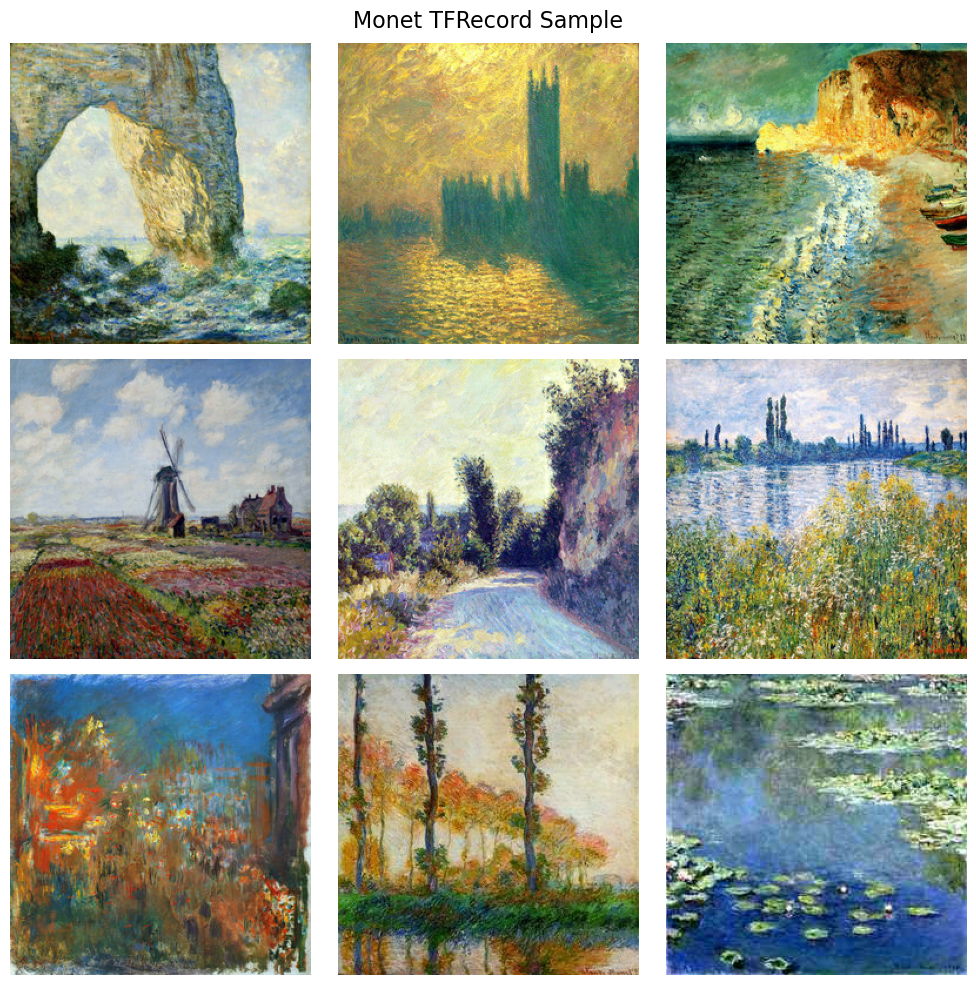

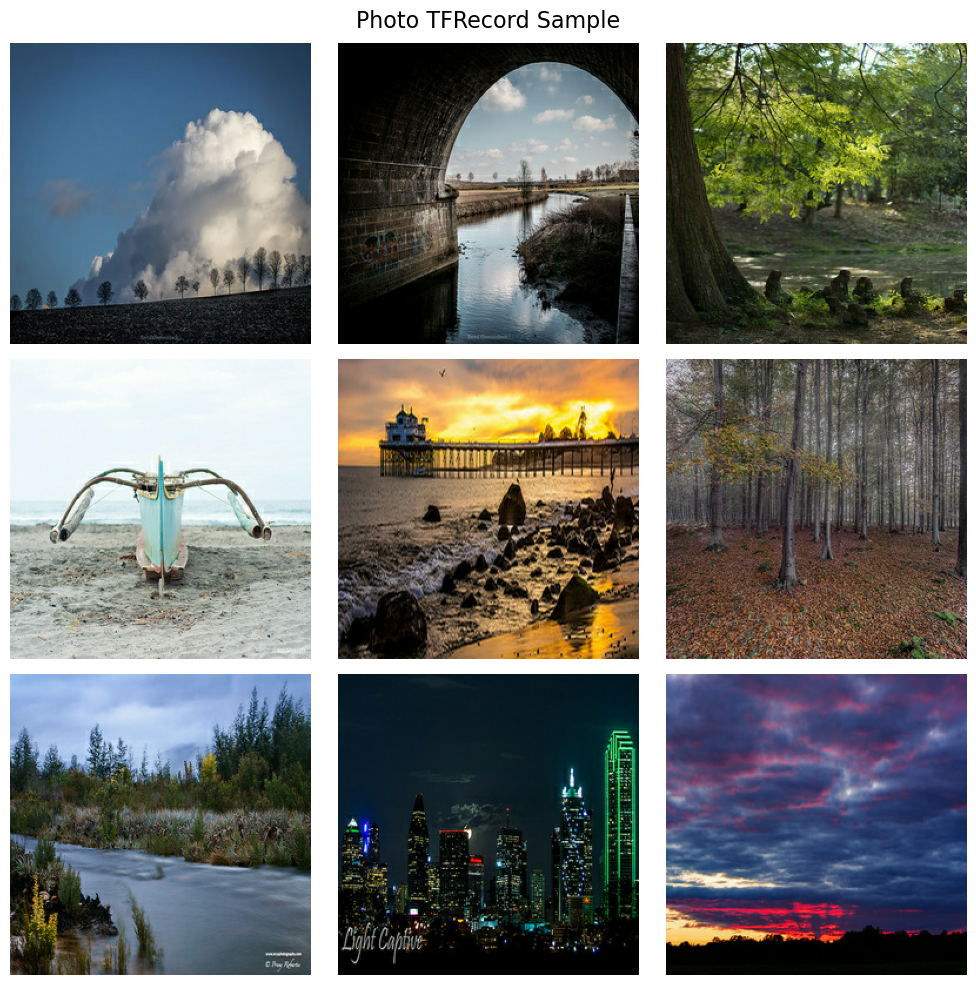

In [11]:
def show_batch_tfrec(dataset, title="Image Batch from TFRecord"):
    plt.figure(figsize=(10, 10))
    for batch in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(batch[i].numpy())
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
show_batch_tfrec(monet_tfrec_ds, title="Monet TFRecord Sample")
show_batch_tfrec(photo_tfrec_ds, title="Photo TFRecord Sample")


# EDA

### Image Count for JPGs

In [16]:

monet_count = sum([len(files) for _, _, files in os.walk(monet_jpg_path)])
photo_count = sum([len(files) for _, _, files in os.walk(photo_jpg_path)])

print(f"Total Monet images: {monet_count}")
print(f"Total Photo images: {photo_count}")


Total Monet images: 300
Total Photo images: 7038


In [24]:
print("Monet image size:", sample_monet.size)
print("Monet image mode:", sample_monet.mode)
print("Photo image size:", sample_photo.size)
print("Photo image mode:", sample_photo.mode)

Monet image size: (256, 256)
Monet image mode: RGB
Photo image size: (256, 256)
Photo image mode: RGB


### Pixel Value Distributions

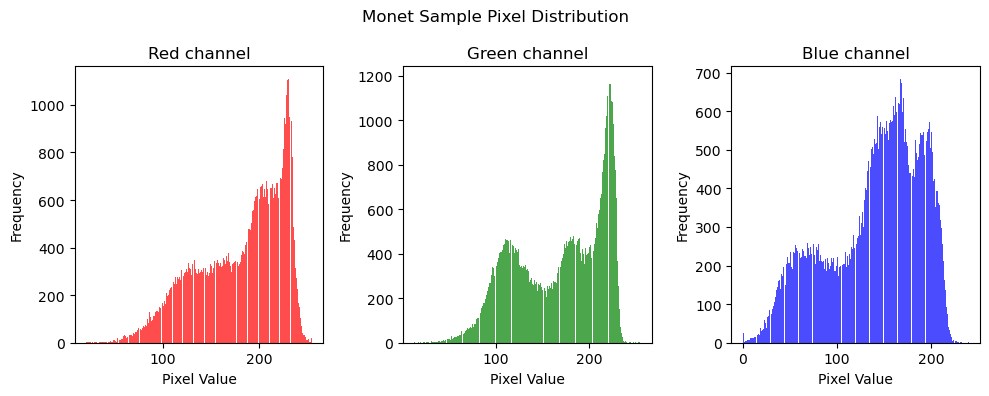

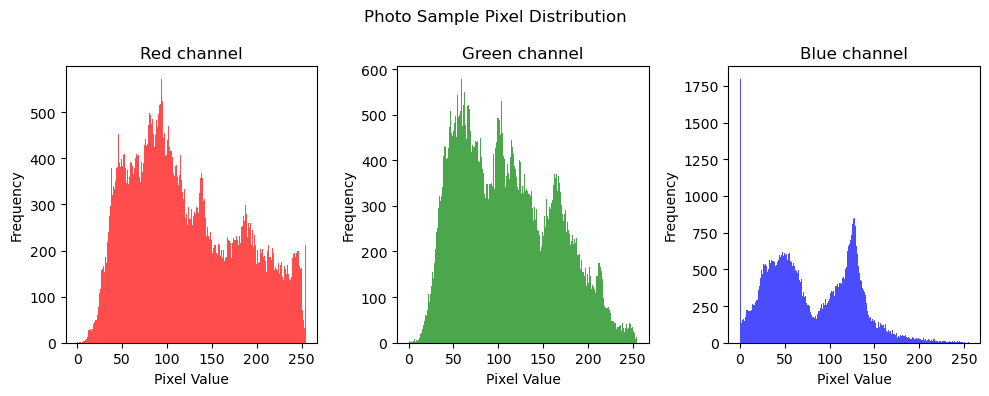

In [26]:
def plot_pixel_distribution(image, title="Pixel Distribution"):
    image_array = np.array(image)
    plt.figure(figsize=(10, 4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i+1)
        plt.hist(image_array[..., i].ravel(), bins=256, color=color.lower(), alpha=0.7)
        plt.title(f"{color} channel")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_pixel_distribution(sample_monet, title="Monet Sample Pixel Distribution")
plot_pixel_distribution(sample_photo, title="Photo Sample Pixel Distribution")

### Check Image Sizes & Modes for JPGs

In [39]:
def check_image_properties(directory):
    sizes = set()
    modes = set()
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img = Image.open(os.path.join(directory, filename))
            sizes.add(img.size)
            modes.add(img.mode)
    return sizes, modes

monet_sizes, monet_modes = check_image_properties(monet_jpg_path)
photo_sizes, photo_modes = check_image_properties(photo_jpg_path)

print("Monet sizes:", monet_sizes)
print("Monet modes:", monet_modes)
print("Photo sizes:", photo_sizes)
print("Photo modes:", photo_modes)


Monet sizes: {(256, 256)}
Monet modes: {'RGB'}
Photo sizes: {(256, 256)}
Photo modes: {'RGB'}


###  Compute RGB Mean and Std from TFRecords

In [48]:
def compute_channel_stats(dataset, num_batches=10):
    means = []
    stds = []
    for i, batch in enumerate(dataset.take(num_batches)):
        arr = batch.numpy()
        means.append(np.mean(arr, axis=(0, 1, 2)))
        stds.append(np.std(arr, axis=(0, 1, 2)))
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean, std

monet_mean, monet_std = compute_channel_stats(monet_tfrec_ds)
photo_mean, photo_std = compute_channel_stats(photo_tfrec_ds)

print("Monet TFRecord - RGB Mean:", monet_mean)
print("Monet TFRecord - RGB Std:", monet_std)
print("Photo TFRecord - RGB Mean:", photo_mean)
print("Photo TFRecord - RGB Std:", photo_std)


Monet TFRecord - RGB Mean: [0.5223518  0.52392614 0.4775045 ]
Monet TFRecord - RGB Std: [0.22598326 0.21896291 0.24682418]
Photo TFRecord - RGB Mean: [0.40240398 0.41256928 0.39280397]
Photo TFRecord - RGB Std: [0.27914193 0.25308424 0.28433564]


Monet images are slightly brighter, particularly in the R/G channels. Photo images have more contrast (higher std), especially in the R channel

### Count Total TFRecord Images

In [45]:
monet_tfrec_len = sum(1 for _ in monet_tfrec_ds.unbatch())
photo_tfrec_len = sum(1 for _ in photo_tfrec_ds.unbatch())

print("Monet TFRecord image count:", monet_tfrec_len)
print("Photo TFRecord image count:", photo_tfrec_len)


Monet TFRecord image count: 300
Photo TFRecord image count: 7038


# Data Preparation

### Normalization

In [59]:
def load_tfrecord_dataset(directory, image_size=(256, 256), mean=None, std=None):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(proto):
        example = tf.io.parse_single_example(proto, feature_description)
        image = tf.io.decode_jpeg(example['image'], channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0

        # Apply normalization if mean and std are provided
        if mean is not None and std is not None:
            image = (image - mean) / std

        return image

    tfrecord_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tfrec')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(_parse_function)
    return dataset.batch(32)


In [61]:
monet_mean = tf.constant([0.5223518, 0.52392614, 0.4775045])
monet_std = tf.constant([0.22598326, 0.21896291, 0.24682418])

photo_mean = tf.constant([0.40240398, 0.41256928, 0.39280397])
photo_std = tf.constant([0.27914193, 0.25308424, 0.28433564])

monet_tfrec_ds = load_tfrecord_dataset(monet_tfrec_path, mean=monet_mean, std=monet_std)
photo_tfrec_ds = load_tfrecord_dataset(photo_tfrec_path, mean=photo_mean, std=photo_std)


### Data Augmentation

In [64]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])


# Model

### Define Generator

In [88]:
def build_generator():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    x = tf.keras.layers.Conv2D(64, 7, padding='same')(inputs)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    for _ in range(6):  # 6 ResNet blocks
        res = x
        x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
        x = norm_layer()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
        x = norm_layer()(x)
        x = tf.keras.layers.add([x, res])

    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)



### Define Discriminator

In [90]:
import tensorflow as tf

def norm_layer():
    return tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-5)

def build_discriminator():
    inputs = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)  # PatchGAN output

    return tf.keras.Model(inputs, x)


###  Initialize Models

In [93]:
# Build the models
G = build_generator()       
F = build_generator()      
D_X = build_discriminator() 
D_Y = build_discriminator() 


### Loss Functions and Optimizers

In [96]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

LAMBDA = 10

def cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))


In [98]:
gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


### Training

In [101]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator forward passes
        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)

        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator predictions
        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Generator losses
        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    gen_G_grads = tape.gradient(total_gen_G_loss, G.trainable_variables)
    gen_F_grads = tape.gradient(total_gen_F_loss, F.trainable_variables)
    disc_X_grads = tape.gradient(disc_X_loss, D_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, D_Y.trainable_variables)

    gen_G_optimizer.apply_gradients(zip(gen_G_grads, G.trainable_variables))
    gen_F_optimizer.apply_gradients(zip(gen_F_grads, F.trainable_variables))
    disc_X_optimizer.apply_gradients(zip(disc_X_grads, D_X.trainable_variables))
    disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, D_Y.trainable_variables))


In [103]:
def train(dataset_X, dataset_Y, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_x, real_y in tf.data.Dataset.zip((dataset_X, dataset_Y)):
            train_step(real_x, real_y)


In [105]:
monet_ds = monet_tfrec_ds.shuffle(300).repeat()
photo_ds = photo_tfrec_ds.shuffle(7038).repeat()


In [107]:
checkpoint_dir = './checkpoints/cyclegan'
os.makedirs(checkpoint_dir, exist_ok=True)


In [109]:
checkpoint = tf.train.Checkpoint(
    G=G,
    F=F,
    D_X=D_X,
    D_Y=D_Y,
    gen_G_optimizer=gen_G_optimizer,
    gen_F_optimizer=gen_F_optimizer,
    disc_X_optimizer=disc_X_optimizer,
    disc_Y_optimizer=disc_Y_optimizer
)

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)


In [111]:
def train(dataset_X, dataset_Y, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_x, real_y in tf.data.Dataset.zip((dataset_X, dataset_Y)):
            train_step(real_x, real_y)

        # Save checkpoint at the end of each epoch
        checkpoint_manager.save()
        print(f" Checkpoint saved at epoch {epoch+1}")


In [113]:
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print("🔁 Restored from", checkpoint_manager.latest_checkpoint)
else:
    print("⚙️ Initializing new model...")


⚙️ Initializing new model...


In [ ]:
train(photo_ds, monet_ds, epochs=100)


Epoch 1/100
